<a href="https://colab.research.google.com/github/esholmess/Skin-Disease-Detection-with-Computer-Vision/blob/main/resnet40%2Bunet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF
import albumentations as A
from albumentations.pytorch import ToTensorV2

from google.colab import files
import zipfile


In [2]:
uploaded =  files.upload()

Saving kto data.zip to kto data.zip


In [4]:
with zipfile.ZipFile("kto data.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

In [5]:
root = "data/kto data"
images_dir = os.path.join(root, "images")
masks_dir = os.path.join(root, "masks")

In [6]:
def convert_mask(mask):
    mask = np.array(mask)
    mask = np.where((mask == 85) | (mask == 170), 1, mask)  # Akciğer
    mask = np.where(mask == 255, 2, mask)                  # Kalp
    return mask.astype(np.uint8)

In [7]:
class LungHeartDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_f = sorted(os.listdir(images_dir))
        self.masks_f = sorted(os.listdir(masks_dir))
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform

    def __len__(self):
        return len(self.images_f)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images_f[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_f[idx])

        image = np.array(Image.open(img_path).convert("L"))
        mask = convert_mask(Image.open(mask_path).convert("L"))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"].long()
        else:
            image = torch.tensor(image / 255.0).unsqueeze(0).float()
            mask = torch.tensor(mask).long()

        return image, mask

In [8]:
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.5),
    A.Normalize(mean=(0.0,), std=(1.0,)),
    ToTensorV2()
])

dataset = LungHeartDataset(images_dir, masks_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)


In [10]:
pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 838.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [10]:
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=3
).to(device)

In [11]:
import torch.nn as nn
from segmentation_models_pytorch.losses import DiceLoss

dice_loss = DiceLoss(mode="multiclass")
ce_loss = nn.CrossEntropyLoss()

def hybrid_loss(pred, target):
    return dice_loss(pred, target) + ce_loss(pred, target)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [12]:
from tqdm import tqdm

model.train()
for epoch in range(10):
    total_loss = 0
    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        preds = model(images)
        loss = hybrid_loss(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss={total_loss / len(train_loader):.4f}")


100%|██████████| 272/272 [00:29<00:00,  9.08it/s]


Epoch 1: Loss=0.6106


100%|██████████| 272/272 [00:26<00:00, 10.41it/s]


Epoch 2: Loss=0.2373


100%|██████████| 272/272 [00:26<00:00, 10.35it/s]


Epoch 3: Loss=0.1627


100%|██████████| 272/272 [00:26<00:00, 10.29it/s]


Epoch 4: Loss=0.1410


100%|██████████| 272/272 [00:26<00:00, 10.18it/s]


Epoch 5: Loss=0.1217


100%|██████████| 272/272 [00:26<00:00, 10.21it/s]


Epoch 6: Loss=0.1041


100%|██████████| 272/272 [00:26<00:00, 10.25it/s]


Epoch 7: Loss=0.1111


100%|██████████| 272/272 [00:26<00:00, 10.28it/s]


Epoch 8: Loss=0.1115


100%|██████████| 272/272 [00:26<00:00, 10.23it/s]


Epoch 9: Loss=0.1009


100%|██████████| 272/272 [00:26<00:00, 10.21it/s]

Epoch 10: Loss=0.0995


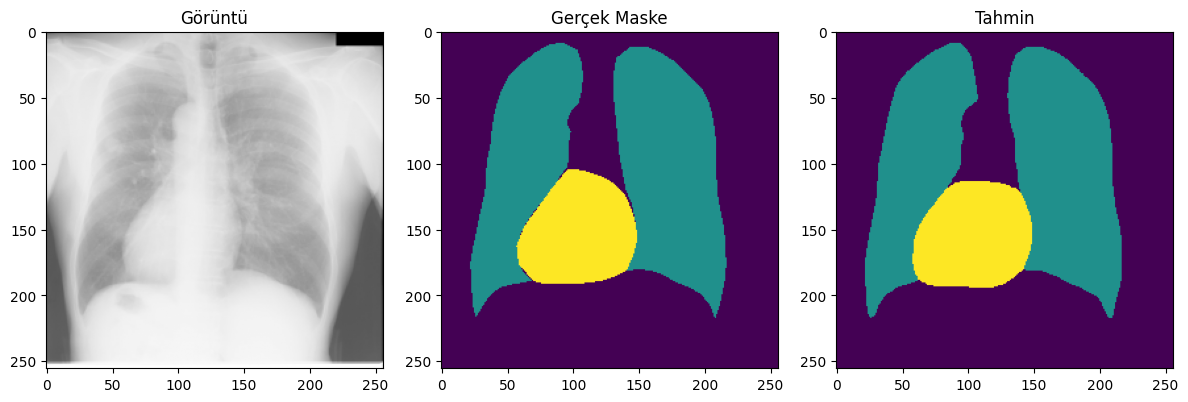

In [13]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    sample_img, sample_mask = dataset[0]
    pred = model(sample_img.unsqueeze(0).to(device))
    pred_label = pred.argmax(dim=1).squeeze().cpu().numpy()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(sample_img.squeeze(), cmap="gray")
plt.title("Görüntü")
plt.subplot(1,3,2)
plt.imshow(sample_mask, cmap="viridis")
plt.title("Gerçek Maske")
plt.subplot(1,3,3)
plt.imshow(pred_label, cmap="viridis")
plt.title("Tahmin")
plt.tight_layout()
plt.show()